In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

## Style Transfer per "A Neural Algorithm of Artistic Style"
- [Lesson 13 Youtube](https://www.youtube.com/watch?v=xXXiC4YRGrQ)
- [DL13 Class Notes](https://medium.com/@hiromi_suenaga/deep-learning-2-part-2-lesson-13-43454b21a5d0)
- [A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576) by Leon A. Gatys, Alexander S. Ecker and Matthias Bethge.

Also, there is a tutorial in Pytorch by Alexis Jacq, "Tutorial to implement A Neural Algorithm of Artistic Style algorithm" 

The Artificial Neural Network (ANN) algorithm takes as input a content-image (e.g. a bird), a style-image (e.g. Van Gogh's Starry Night) and returns a new image with content similar to the content-image but as if it was 'painted' using the artistic style of the style-image.

### Content and Style distances
We define two distances between 2 images $X$ and $Y$:  
$D_C(X, Y)$ measures how different the content is between the images, 
and $D_S(X, Y)$ measures their difference in style.
Then, we take a third image $Z$, (e.g., $Z$ can be the input or the input image with noise), 
and we transform it to both minimize its $D_C(X, Z)$ with the content-image $X$
and its $D_S(Y, Z)$ with the style-image $Y$.
- Let $X$ be any 2-dimensional image, and $|X|$ be the "size" of the image $X$. 
- Let $C_{nn}$ be a pre-trained deep Convolutional Neural Network (CNN) with layers $l \in \Lambda$. 
- Let $C_{nn}(X)$ be the network fed by $X$ (containing feature maps at all layers). 
- Let $F_{XL} \in C_{nn}(X)$ be the *feature maps* at depth layer $L$, 
(all vectorized and concatenated in one single vector.) 

- Define $F_{XL}$ as the *content* of $X$ at layer $L$. 

#### Content Distance
Then, if $Y$ is another image, such that $|X| = |Y|$, (equal size), 
we define the **distance of content at layer $L$** as:

\begin{align}D_C^L(X,Y) = \|F_{XL} - F_{YL}\|^2 = \sum_i (F_{XL}(i) - F_{YL}(i))^2\end{align}

Where $F_{XL}(i)$ is the $i^{th}$ element of $F_{XL}$.

#### Style Distance
The **style** is more difficult to define. <br>
Let $F_{XL}^k$ with $k \leq K$ be the vectorized $k^{th}$ of the $K$ feature maps at layer $L$. <br>
The style $G_{XL}$ of $X$ at layer $L$ is defined by the **Gram product** of all vectorized
feature maps $F_{XL}^k$ with $k \leq K$. <br>
In other words,
$G_{XL}$ is a $K$ by $K$ matrix and the element
$G_{XL}(k,l)$ at the $k^{th}$ line and $l^{th}$ column
of $G_{XL}$ is the vectorial product between $F_{XL}^k$ and $F_{XL}^l$ :

\begin{align}G_{XL}(k,l) = \langle F_{XL}^k, F_{XL}^l\rangle = \sum_i F_{XL}^k(i) . F_{XL}^l(i)\end{align}

Where $F_{XL}^k(i)$ is the $i^{th}$ element of $F_{XL}^k$. 

$G_{XL}(k,l)$ is a measure of the **correlation** between feature maps $k$ and $l$. <br>
In that way, $G_{XL}$ represents the correlation matrix of feature maps of $X$ at layer $L$. <br>
Note that the size of $G_{XL}$ only depends on the number of feature maps, not on the size of $X$.<br>
Then, if $Y$ is another image *of any size*, we define the distance of style at layer $L$ as:

\begin{align}D_S^L(X,Y) = \|G_{XL} - G_{YL}\|^2 = \sum_{k,l} (G_{XL}(k,l) - G_{YL}(k,l))^2\end{align}

### Minimazing both distances simultaneously
To minimize, in one shot, the distances $D_C(X,C)$ and $D_S(X,S)$, 
we compute and sum the gradients (derivative with respect to $X$) of each distance at each wanted layer:

\begin{align}\nabla_{	extit{total}}(X,S,C) = \sum_{L_C} w_{CL_C}.\nabla_{	extit{content}}^{L_C}(X,C) + \sum_{L_S} w_{SL_S}.\nabla_{	extit{style}}^{L_S}(X,S)\end{align}

Where $L_C$ and $L_S$ are the wanted layers (arbitrary stated) of content and style 
and $w_{CL_C}$ and $w_{SL_S}$ the weights (arbitrary stated) associated with the
style or the content at each wanted layer. 
Then, we run a gradient descent over $X$:

\begin{align}X \leftarrow X - \alpha \nabla_{	extit{total}}(X,S,C)\end{align}

## Style transfer in Fastai

In [2]:
from fastai.conv_learner import *
from pathlib import Path
from scipy import ndimage
#torch.cuda.set_device(3)

torch.backends.cudnn.benchmark=True

In [3]:
%pwd

'/home/german/DeepLearning'

Goal: Take a photo (eg of a bird), and create a painting that looks like (e.g., Van Gogh) painted the picture of the bird. 
There is an [ImageNet sample](http://files.fast.ai/data) 
which should be enough for everything we are doing. 
To get great results, get ImageNet, eg download it from Kaggle.  
The localization competition actually contains all of the classification data as well. 

[1:03:44]. 
F is a loss function that take as input a picture and outputs a value, 
which is lower if the image looks more like the bird photo painted by Van Gogh. 
With F, we use PyTorch gradient and optimizers. 
Gradient times the learning rate, BUT we are **not** going to update any weights.
Instead, we are going to update the pixels of the input image 
to make it a little bit more like a picture which would be painted by Van Gogh.
We will stick it through F again to get more gradients, and repeat.

This is DL: Create a loss function, use it to get some gradients, multiply it by learning rates to update something, always before, we’ve updated weights in a model.
But today, we are going to **update the pixels in the input.** 
Other than that, it’s no different. 
We take the gradient with respect to the input rather than with respect to the weights. 
[1:05:49]. 
There are two more inputs to the loss function: 
$X$ the picture of the bird, and $Y$ an artwork by Van Gogh. 
By having those as inputs, we will be able to rerun the function later,
e.g. to make it look like a bird painted by Monet, (or a jumbo jet painted by Van Gogh), etc. 
 
Initially, the input is some random noise, we use the loss function, get the gradients, 
make it a little bit more like a bird painted by Van Gogh, and so forth.

How we calculate how much our image looks like this bird painted by Van Gogh [1:07:09]. 
Let’s split it into two parts:
- Content Loss: a value that’s lower if it looks more like the (specific) bird.
- Style Loss: Returns a lower number if the image is more like V.G.’s style

Content loss can be very simple — 
Compare the pixels of the output and input, do a MSE, and add them up. 
Eventually the (noise) image would turn into an image of the bird. 
Exercise: use the optimizer in PyTorch to start with a random image and turn it into another image by 
using MSE error pixel loss. 

But, there is a problem. 
Assuming we had a style loss and we picked a sensible lambda.
If we used pixel-wise content loss, then anything that makes it look more like Van Gogh 
and less like the exact photo, (exact background, contrast, lighting, etc.) 
will increase the content loss.
That is not what we want. 

We want it to look like the bird but not in the same way. 
It should still have eyes in the same place, same shape, etc., 
but not the same representation. 
So we are going to use a ANN, here `VGG`.

VGG takes an input and sticks it through a number of layers, and we treat these as just convolutional layers.
(there’s obviously ReLU there and if it’s a VGG with batch norm, which most are today, then it’s also got batch norm. 
There’s some max pooling and so forth but that’s fine.)

We take one of the convolutional activations (layers, eg 5) 
and rather than comparing the pixels of this bird, we instead compare:
- the VGG layer 5 activations of this (bird painted by V.G.) 
- to the VGG layer 5 activations of our original bird. 

These are more interesting, because it wouldn’t be the exact original image (bird).
We are not looking at the pixels, but rather some later set of activations. 
What do those later sets of activations contain? 
Assuming it’s after some (max?) pooling, they contain a smaller grid,
so it’s less specific about where things are. 
Rather than containing pixel color values, they are more semantic things like: 
is this an eyeball, furry, bright, reflective, laying flat, etc.<br> 
There’s some semantic features through those layers,
where if we get a picture that matches those activations, 
then any picture that matches those activations "looks like" the bird,
but it’s not the same representation of the bird. 

A **perceptual loss** compares two activations together. 
The content loss is going to be a perceptual loss. 
Then we will do the style loss later.

We start by trying to create a bird from random noise, 
and we use perceptual loss to create something that is bird-like (but not the particular bird) [1:13:13]. 
We start with 288x288. 
Because do just 1 (bird) image, there are no GPU memory problems.
Note that we could do a whole batch at a time. 
Some complained that Gatys’ style transfer is slow, but it takes 
only a few seconds and we can do a whole batch in a few seconds.

In [4]:
PATH = Path('/data/gsg/imagenet/ILSVRC/Data/CLS-LOC/')
PATH_TRN = PATH/'train'

In [5]:
m_vgg = to_gpu(vgg16(True)).eval()
set_trainable(m_vgg, False)

Grab a bird out of Imagenet.

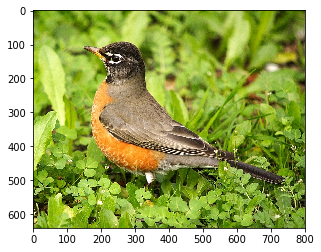

In [58]:
img_fn = PATH_TRN/'n01558993'/'n01558993_6183.jpg' #9684.jpg' #JPEG'
img = open_image(img_fn)
plt.imshow(img);

In [59]:
sz=288

So we are going to stick it through some transforms for the VGG16 model as usual [1:14:12]. 
The transform class has a dunder call method (__call__) so we can treat it as if it’s a function. 
If you pass it an image, then we get the transformed image:
```
img_tfm = val_tfms(img)
```
fast.ai and PyTorch are designed to be easy to decouple. 
The idea that transforms are just “callables” (i.e. things that you can do with parentheses) comes from PyTorch.
And the whole pipelines of transforms is just a callable.

In [60]:
trn_tfms,val_tfms = tfms_from_model(vgg16, sz)
img_tfm = val_tfms(img)
img_tfm.shape

(3, 288, 288)

Now we have something of 3x288x288, since PyTorch likes the channel to be first [1:15:05]. 
Notice it has been turned into a square and normalized to (0, 1).<br>
Now we are creating a random image to start with:

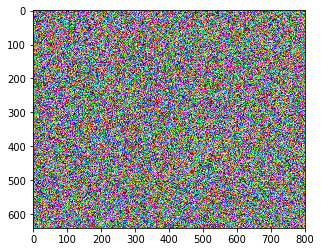

In [61]:
opt_img = np.random.uniform(0, 1, size=img.shape).astype(np.float32)
plt.imshow(opt_img);

In [62]:
opt_img = scipy.ndimage.filters.median_filter(opt_img, [8,8,1])

Above makes it smoother.
Trying to turn this into a picture of anything is hard for an optimizer to get reasonable gradients.
The key issue is that pictures don’t look like the above noise. 
They have more smoothness. 
We blurred it using a median filter, like a median pooling, effectively. 

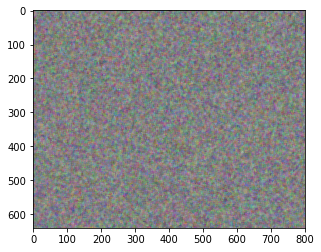

In [63]:
plt.imshow(opt_img);

So we start with a random image which is at least somewhat smooth [1:16:21]. 
The bird image had a mean of pixels that was about half of this, 
so divided it by 2 just to make it easier for it to match (I don’t know if it matters). 
Turn into a variable (V), as we are going to be modifying those pixels with an optimization algorithm, 
anything that’s involved in the loss function needs to be a variable. 
And specifically, it requires a gradient because we are updating the image.

In [64]:
opt_img = val_tfms(opt_img)/2
opt_img_v = V(opt_img[None], requires_grad=True)
opt_img_v.shape

torch.Size([1, 3, 288, 288])

So we now have a mini batch of 1, 3 channels, 288x288 random noise.

We are going to use, for no particular reason, the 37th layer of VGG (a mid to late stage layer). 
We can the VGG network by just typing `m_vgg`. 
We grab the first 37 layers and turn it into a sequential model. 
```
nn.Sequential(*children(m_vgg)[:37])
```
Now we have a subset of VGG that will spit out some mid layer activations, 
and that’s what the model is going to be. 

So we can take our actual bird image and we want to create a mini batch of one. 
If we slice in Numpy with `[None]`, aka `np.newaxis`, it introduces a new unit axis in that point. 
We want to create an axis of size 1 to be a minibatch of size one. 

So we slice with None (`opt_img_v = V(opt_img[None], requires_grad=True)`) 
to get one unit axis at the front. 
Then we turn that into a variable, but this one doesn’t need to be updated.
So we use VV to say you don’t need gradients for this one. 
So that is going to give us our target activations.

In [65]:
m_vgg = nn.Sequential(*children(m_vgg)[:37])

In [66]:
targ_t = m_vgg(VV(img_tfm[None]))
targ_v = V(targ_t)
targ_t.shape

torch.Size([1, 512, 18, 18])

Below we use the LBFGS optimizer. 
Usually this optimizer is **not** a good idea in DL (for optimizing weights):  
- more work than Adam or SGD 
- more memory — a big issue for GPUs 
- mini-batch is super bumpy 
- "magnet" for saddle points. 

But [1:26:40], we are optimizing **pixels** so rules change and BFGS make sense. 

In [67]:
max_iter = 1000
show_iter = 100
optimizer = optim.LBFGS([opt_img_v], lr=0.5)

In [68]:
def actn_loss(x): return F.mse_loss(m_vgg(x), targ_v)*1000

In [69]:
def step(loss_fn):
    global n_iter
    optimizer.zero_grad()
    loss = loss_fn(opt_img_v)
    loss.backward()
    n_iter+=1
    if n_iter%show_iter==0: print(f'Iteration: {n_iter}, loss: {loss.data[0]}')
    return loss

Summary: We’ve 
- taken our bird image
- turned it into a variable
- stuck it through the model to grab the 37th layer activations which is our target. We want our content loss to be this set of activations.
- create an optimizer 
- step a bunch of times
- Zero the gradients
- Call some loss function
- Loss.backward()

We are passing in the randomly generated image, the variable of optimization image, to the loss function.
It will update this using the loss function, which is MSE.
The loss function compares our current optimization image variable to our target activations. 
We run that a few times and print it out. 
And we have our bird but not the representation of it.

In [70]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,actn_loss))

Iteration: 100, loss: 0.7071636319160461
Iteration: 200, loss: 0.322167307138443
Iteration: 300, loss: 0.22071786224842072
Iteration: 400, loss: 0.17041455209255219
Iteration: 500, loss: 0.14210180938243866
Iteration: 600, loss: 0.12454808503389359
Iteration: 700, loss: 0.11262466013431549
Iteration: 800, loss: 0.10441093146800995
Iteration: 900, loss: 0.09801244735717773
Iteration: 1000, loss: 0.0929725244641304


Because this optimizer does more work each time, the API is different in PyTorch. 
When you say `optimizer.step`, you actually pass in the loss function. 
So we call step with a particular loss function, which is our activation loss (`actn_loss`). 
And inside the loop, you don’t say step, step, step. 
But rather it looks like this. 
So it’s a little bit different.
It could be done w/SGD, but it’ll take longer.

In [72]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]
plt.figure(figsize=(7,7))
x=np.clip(x,0,1)   # This was needed to prevent crashing, as the library was no longer doing the clip automatically.

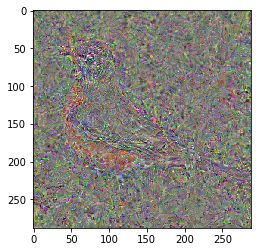

In [73]:
plt.imshow(x);

The loss function is going down [1:27:38]. 
The MSE between the activations at layer 37 of VGG for our optimized image vs. the target activations.
(target activations were the VGG applied to the bird). 
So now got a content loss. 
For content loss we don’t know which layer is going to work the best. 
It would be good to experiment more. 
And the way we did above is not good and annoying:

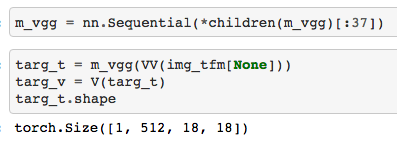

Maybe we even want to use multiple layers. 
Rather than "lopping off" all of the layers after the one we want, 
we would like to grab the activations of a few layers, as it calculates. 
Now, we already know one way to do that.
When we did SSD, we wrote our own network which had a number of outputs,  
different convolutional layers, we spat out a different oconv thing, etc. 
But we don’t really want to go and add that to the torch.vision ResNet model.
Especially not if later on, I want to try torch.vision VGG model, 
and then I want to try NASNet-A model.
Don’t want to go into all of them and change their outputs. 
We would like to easily be able to turn certain activations on and off on demand. 

So lets use PyTorch **hooks.** 
A forward (backward) hook lets us plug anything into the forward (backward) pass of a calculation.
So lets create a simple forward hook.

## forward hook

Few know about hooks..
Most code that implements style transfer will have "horrible hacks" instead of forward hooks. <br>
To create a forward hook, we create a class with a `hook_fn`. 
The hook function receives the `module` that you’ve hooked, 
the `input` for the forward pass, and the `output`.
Then we can do whatever.<br>
Below, we just store the output of the module in an attribute. 
`hook_fn` can be called anything, but “hook_function” seems to be the standard.<br>
In the constructor, we store inside some attribute `self.hook`
the result of `m.register_forward_hook` (`m` is going to be the layer that we are going to hook). 
We pass in the function that we want to be called when the module’s forward method is called. 
So, when its forward method is called, it will call `self.hook_fn` 
which will store the output in an attribute called `features`.

In [74]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def close(self): self.hook.remove()

So now what we can do is we can create a VGG as before. 
We set it to not trainable to avoid time and memory waste calculating gradients for it. 

In [75]:
m_vgg = to_gpu(vgg16(True)).eval()
set_trainable(m_vgg, False)

Now let’s go through and find all the max pool layers. 
We go through all of the children of this module and for each, 
if it’s a maxpool layer, let’s spit out index minus 1, i.e. return the layer before the maxpool. 
In general, the layer before a maxpool or the one before a stride 2 conv is a very interesting layer. 
It’s the most complete representation we have at that grid cell size.
The very next layer is changing the grid. 
So that is a good place to grab the content loss from, 
it is the most semantic, most interesting content we have at that grid size. 

In [76]:
block_ends = [i-1 for i,o in enumerate(children(m_vgg))
              if isinstance(o,nn.MaxPool2d)]
block_ends

[5, 12, 22, 32, 42]

These are the indexes of the last layer before each maxpool in VGG [1:32:30].
We grab 32 (`block_ends[3]`)— no particular reason, just try something else. 
So `children(m_vgg)[block_ends[3]]` returns the 32nd layer of VGG as a module.

In [77]:
sf = SaveFeatures(children(m_vgg)[block_ends[3]])

In [78]:
def get_opt():
    opt_img = np.random.uniform(0, 1, size=img.shape).astype(np.float32)
    opt_img = scipy.ndimage.filters.median_filter(opt_img, [8,8,1])
    opt_img_v = V(val_tfms(opt_img/2)[None], requires_grad=True)
    return opt_img_v, optim.LBFGS([opt_img_v])

In [79]:
opt_img_v, optimizer = get_opt()

Below is calling the VGG network, but not storing it anywhere. 
It is not saying `activations = m_vgg(VV(img_tfm[None]))`.<br> 
Just calling it, throwing away the answer, and then grabbing the features stored in the `SaveFeatures` object.

`m_vgg()` — this is how to do a forward path in PyTorch. <br>
We don’t say `m_vgg.forward()`, just call it, i.e., a callable on an nn.module automatically calls forward. 
That’s how PyTorch modules work.<br>
We call it as a callable, that calls the forward hook, which stores the activations in `sf.features`.
So now we have our target variable, just like before but in a more flexible way.

`get_opt` contains the same 4 lines of code we had earlier [1:34:34]. 
It is just giving a random image to optimize and an optimizer to optimize that image.

In [80]:
m_vgg(VV(img_tfm[None]))
targ_v = V(sf.features.clone())
targ_v.shape

torch.Size([1, 512, 36, 36])

In [81]:
def actn_loss2(x):
    m_vgg(x)
    out = V(sf.features)
    return F.mse_loss(out, targ_v)*1000

Now we can go ahead and do exactly the same thing. 
But now we are going to use a different loss function `actn_loss2` (activation loss #2),
which doesn’t say `out=m_vgg`.
Again, it calls `m_vgg` to do a forward pass, throws away the results, and grabs `sf.features`. 
That is now the 32nd layer activations, which we can do the MSE loss on. <br>

NB: the last loss function and this one are both multiplied by 1000. 
Why? 
Because it wasn’t training. 
JH noticed that the loss numbers were very low (like $10^{-7}$).
So he multiplied by a 1000 and it started working. 
Why did it not work? Because of single precision floating point.
Once we get gradients that are small, and they are multiplying by $\mu$ that can be small, 
we end with small numbers. 
If too small, they could get rounded to 0, and that’s what was happening.
There must be better ways than multiplying by 1000.
It doesn’t matter what factor to multiply a loss function,
because we only care about is its direction and the relative size. 

Interestingly, it is a standard practice to get the Half Precision Floating Point (HPFP) to train, 
to multiply the loss function by a scaling factor, e.g. 1024 or 512. 
Fast.ai is the first library that has all what is necessary to train in HPFP.
So if we have a Volta (eg on AWS P3), use learn.half, and it will train correctly on HPFP. 
It is built into the model data object as well, and it’s all automatic. 

In [82]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,actn_loss2))

Iteration: 100, loss: 0.2431444227695465
Iteration: 200, loss: 0.11069674789905548
Iteration: 300, loss: 0.07274418324232101
Iteration: 400, loss: 0.05589733645319939
Iteration: 500, loss: 0.045773785561323166
Iteration: 600, loss: 0.039221204817295074
Iteration: 700, loss: 0.03455602750182152
Iteration: 800, loss: 0.030930139124393463
Iteration: 900, loss: 0.028121016919612885
Iteration: 1000, loss: 0.02585466392338276


This is just doing the same thing on a slightly earlier layer [1:37:35]. 
And the bird looks more bird-like. 
Earlier layers are getting closer to the pixels. 
There are more grid cells, each cell is smaller, smaller receptive field, less complex semantic features. 
So the earlier we get, the more it’s going to look like a bird.

(-0.5, 287.5, 287.5, -0.5)

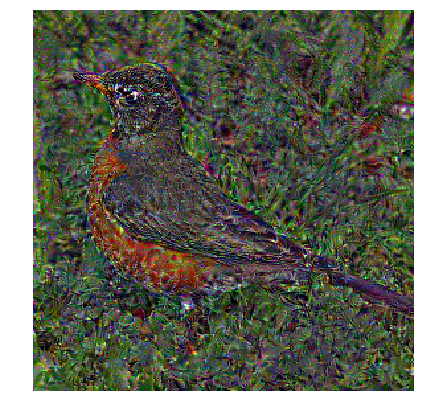

In [84]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]
plt.figure(figsize=(7,7))
x=np.clip(x,0,1)
plt.imshow(x);
plt.axis('off')

The paper shows different layers zooming into a house [1:38:17]. 
They are trying to make this house look like The Starry Night picture. 
Later on it’s pretty messy, and earlier on it looks like the house. 
So this is just doing what we just did.
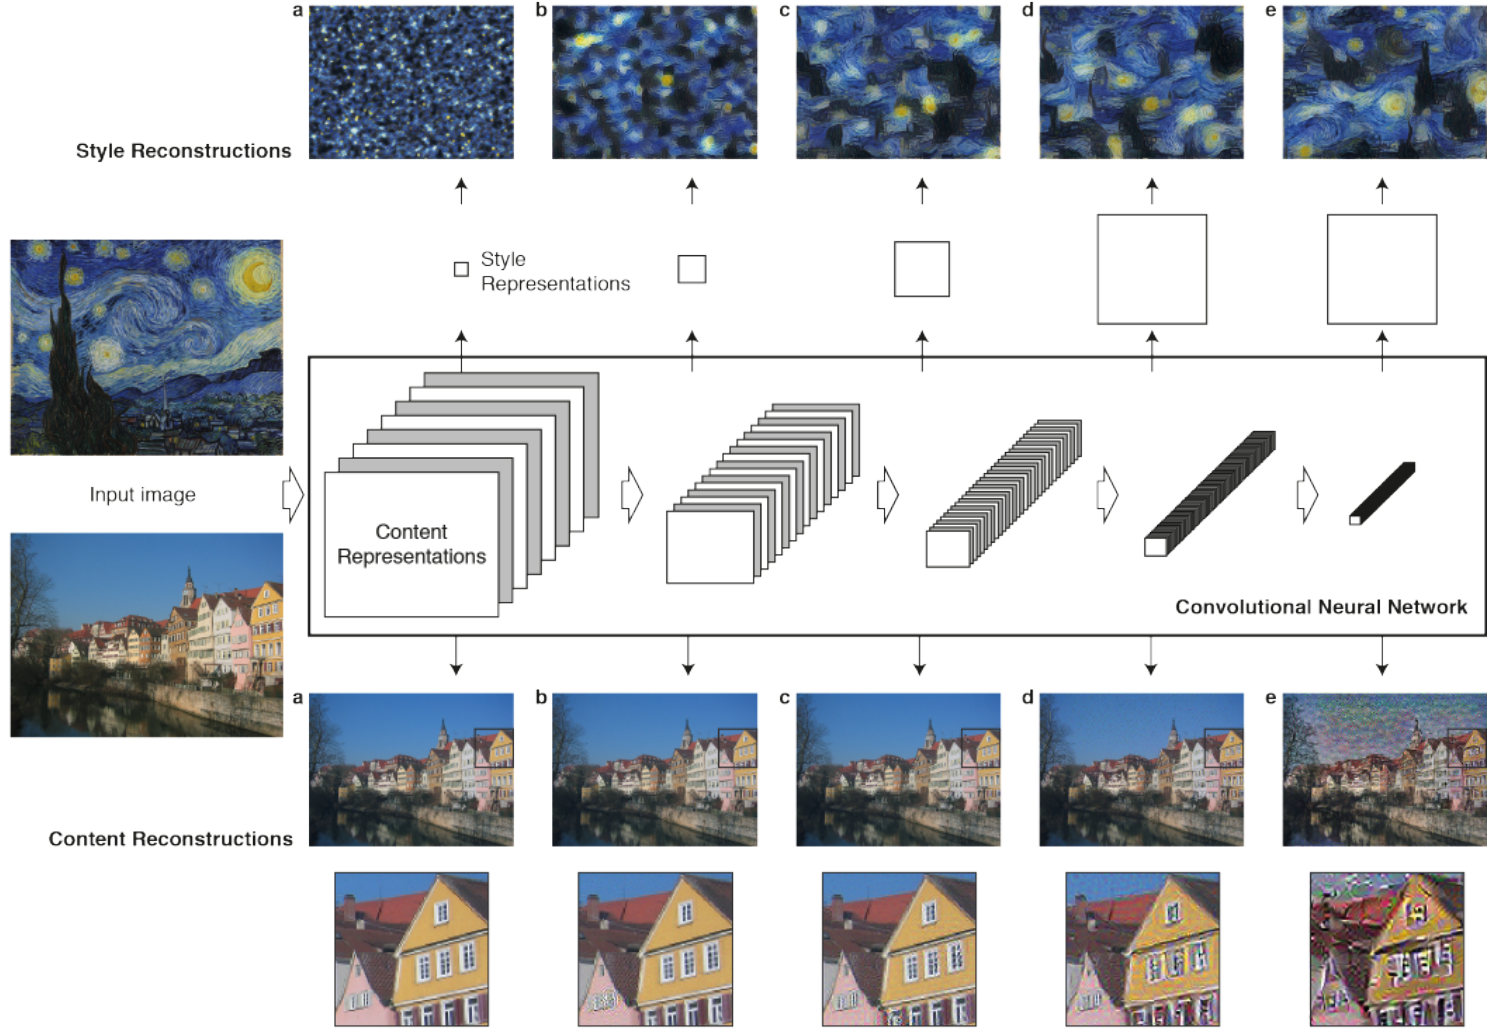

In [85]:
sf.close()

## Style match
Now we need the style loss, how like this painting style is it. 
And we are going to do nearly the same thing. 
We are going to grab the activations of some layer. 

Let’s look at our Van Gogh painting. There it is — The Starry Night

In [86]:
style_fn = '/data/style/starry_night.jpg'

In [87]:
style_img = open_image(style_fn)
style_img.shape, img.shape

((240, 301, 3), (640, 800, 3))

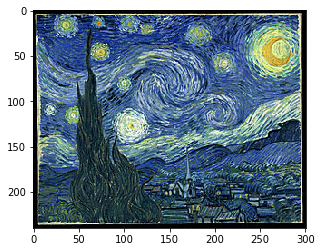

In [88]:
plt.imshow(style_img);

So we can do that for our Van Gogh image and we can do that for our optimized image. 
Then we can compare the two and we would end up creating an image that has content like the painting,
but it’s not the painting — that’s not what we want. 
We want something with the same style but it’s not the painting and doesn’t have the content. 
We want to throw away all of the spatial information. 
We are not trying to create something that has a moon here, stars here, and a church here. 
We don’t want any of that. 
How do we throw away all the special information?

Graphical illustration:
In this case, there are 19 faces on this — 19 slices (per VGG). 
So let’s grab this top slice that’s going to be a 5x5 matrix. 
Now, let’s flatten it and we’ve got a 25 long vector. 
In one stroke, we’ve thrown away the bulk of the spacial information by flattening it. 

Now let’s grab a second slice (i.e. another channel) and do the same thing. 
So we have channel 1 flattened and channel 2 flattened, and they both have 25 elements. 
Now, let’s take the dot product which we do with `@` in Numpy 

The dot product gives us one number. What’s that number? What is it telling us? 
Assuming the activations are somewhere around the middle layer of the VGG network, 
we might expect some of these activations to be:
- how textured is the brush stroke, 
- how bright is this area, 
- is this part of a house, 
- how dark is this part of the painting. 

A dot product is basically a correlation. 
If the [i] element on both are both highly positive or both highly negative, it gives us a big result. 
Where else, if they are the opposite, it gives a small results. 
If they are both close to zero, it gives no result. 
So basically **a dot product is a measure of how similar these two things are**. 

Let’s give an example [1:44:28]. 
Let’s say the first one was how textured are the brushstrokes (C1) 
and that one there says how diagonally oriented are the brush strokes (C2).

If C1 and C2 are both high for a cell (1, 1) at the same time, and same is true for a cell (4, 2), 
then it’s saying grid cells that would have texture tend to also have diagonal. 
So dot product would be high when grid cells that have texture also have diagonal, 
and when they don’t, they don’t (have high dot product). 
So that’s C1 @ C2. 

C1 @ C1 is the 2-norm effectively (i.e. the sum of the squares of C1). 
This is basically saying how many grid cells in the textured channel is active and how active it is. 
C1 @ C1 tells us how much textured painting is going on. 
And C2 @ C2 tells us how much diagonal paint stroke is going on. 
Maybe C3 is “is it bright colors?” so C3 @ C3 would be how often do we have bright colored cells.

So what we could do then is we could create a 19 by 19 matrix containing every dot product [1:47:17]. 
The matrix where you flatten something out and then do all the dot product is called `Gram matrix`.

[1:49:22].  
The Gram matrix is a map — the diagonal is perhaps the most interesting, 
which channels are the most active and then the off diagonal is which channels tend to appear together. 
And overall, if two pictures have the same style, 
then we are expecting that some layer of activations, they will have similar Gram matrices. 
Because if we found the level of activations that capture a lot of stuff about like paint strokes and colors, 
then the diagonal alone (in Gram matrices) might even be enough. 

TODO: try doing Gattys’ style transfer not using the Gram matrix but just using the diagonal of the Gram matrix. 
That would be like a single line of code to change. 
A student (Christine) tried. "It works most of the time, 
except when you have funny pictures where you need two styles to appear in the same spot. 
So it seems like grass in one half and a cloud in one half, and you need the two styles.”

In [89]:
def scale_match(src, targ):
    h,w,_ = src.shape
    sh,sw,_ = targ.shape
    rat = max(h/sh,w/sw); rat
    res = cv2.resize(targ, (int(sw*rat), int(sh*rat)))
    return res[:h,:w]

In [90]:
style = scale_match(img, style_img)

((640, 800, 3), (640, 800, 3))

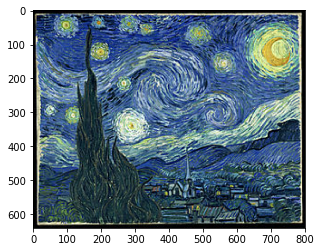

In [91]:
plt.imshow(style)
style.shape, img.shape

So here is our painting [1:51:22]. 
We resize the painting so it’s the same size as the bird picture. 
It doesn’t matter too much which bit I use as long as it’s got lots of the nice style in it.
We grab the optimizer and random image just like before:

In [92]:
opt_img_v, optimizer = get_opt()

And this time, we call SaveFeatures for all the `block_ends`.
That is going to give us an array of `SaveFeatures` objects — 
one for each module that appears the layer before the max pool. 
Because this time, we want to play around with different activation layer styles, 
we've got a whole array of them.

In [93]:
sfs = [SaveFeatures(children(m_vgg)[idx]) for idx in block_ends]

In [94]:
m_vgg(VV(img_tfm[None]))
targ_vs = [V(o.features.clone()) for o in sfs]
[o.shape for o in targ_vs]

[torch.Size([1, 64, 288, 288]),
 torch.Size([1, 128, 144, 144]),
 torch.Size([1, 256, 72, 72]),
 torch.Size([1, 512, 36, 36]),
 torch.Size([1, 512, 18, 18])]

We put `style_img` (the VanGogh painting) through the transformations to create a transformed style image (`style_tfm`).

In [95]:
style_tfm = val_tfms(style_img)

Turn that into a variable, put it through the forward pass of my VGG module, and now I can go through all of my SaveFeatures objects and grab each set of features. 
Notice I call clone because later on, if I call my VGG object again, it’s going to replace those contents. 
I haven’t quite thought about whether this is necessary. 
If you take it away and it’s not, that’s fine. 
But I was just being careful. 
So here is now an array of the activations at every `block_end` layer. 
Below are all of those shapes:

In [96]:
m_vgg(VV(style_tfm[None]))
targ_styles = [V(o.features.clone()) for o in sfs]
[o.shape for o in targ_styles]

[torch.Size([1, 64, 288, 288]),
 torch.Size([1, 128, 144, 144]),
 torch.Size([1, 256, 72, 72]),
 torch.Size([1, 512, 36, 36]),
 torch.Size([1, 512, 18, 18])]

Being able to whip up a list comprehension quickly, is important. [1:53:30]. 
We want to immediately see here’s my channel (64, 128, 256, …), 
and grid size halving as we would expect (288, 144, 72…) 
because all of these appear just before a max pool.

In [97]:
def gram(input):
        b,c,h,w = input.size()
        x = input.view(b*c, -1)
        return torch.mm(x, x.t())/input.numel()*1e6

def gram_mse_loss(input, target): return F.mse_loss(gram(input), gram(target))

So to do a Gram MSE loss, it’s going to be the MSE loss on the Gram matrix of the input vs. the Gram matrix of the target. 
And the Gram matrix is the matrix multiply of `x` with $x^T$ `(x.t())` 
where x is the input flattened the batch and channel axes all together. 
As we only got one image, we can ignore the batch — it’s basically channel. 
Then everything else (-1), which in this case is the height and width, 
is the other dimension because there’s now going to be channel by height and width.
We can just do the matrix multiply of that by its transpose. 
To normalize it, we divide that by the `input.numel` (number of elements). 
Again, this gave tiny numbers so we multiply it by $e^6$ (a big number), and that’s the loss.

So now my style loss is to:
- take my image to optimize, 
- throw it through VGG forward pass, 
- grab an array of the features in all of the SaveFeatures objects, 
- call Gram MSE loss on every one of those layers 
[1:55:13]. 
And that’s going to give an array and then we just add them up. 
Now we could add them up with different weightings, add up subsets, or whatever. 
In this case, we just grab all of them.

In [98]:
def style_loss(x):
    m_vgg(opt_img_v)
    outs = [V(o.features) for o in sfs]
    losses = [gram_mse_loss(o, s) for o,s in zip(outs, targ_styles)]
    return sum(losses)

Pass that into my optimizer as before:

In [99]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,style_loss))

Iteration: 100, loss: 221.1231231689453
Iteration: 200, loss: 80.33126831054688
Iteration: 300, loss: 34.382659912109375
Iteration: 400, loss: 18.354921340942383
Iteration: 500, loss: 12.000401496887207
Iteration: 600, loss: 8.951062202453613
Iteration: 700, loss: 7.305672645568848
Iteration: 800, loss: 6.29769229888916
Iteration: 900, loss: 5.617255210876465
Iteration: 1000, loss: 5.133820056915283


And here we have a cool random image in the style of Van Gogh.

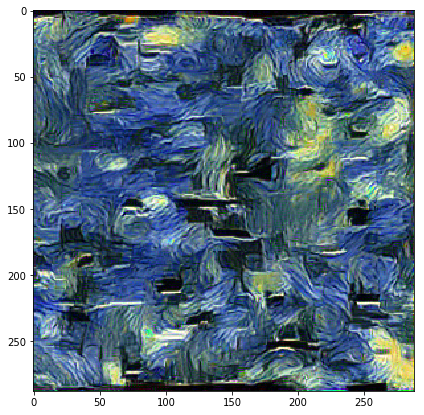

In [100]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]
plt.figure(figsize=(7,7))
x=np.clip(x,0,1)
plt.imshow(x);

Again Gattys has done it for us. 
Here are different layers of random image in the style of Van Gogh. 
The first one, the activations are simple geometric things — not very interesting. 
The later layers are more interesting. 
So we probably want to use later layers largely for the style loss to look good.

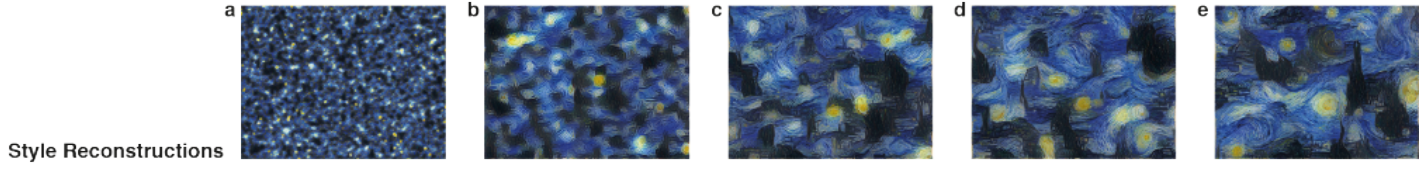

In [101]:
#for sf in sfs: sf.close()   # Was this creating errors?

Notice earlier we had `SaveFeatures.close` [1:56:35] which just calls self.hook.remove(). 
We stored the hook as self.hook so `hook.remove()` gets rid of it. 
It’s a good idea to get rid of it because otherwise you can potentially just keep using memory. 
So at the end, I just go through each of my SaveFeatures object and close it:

## Style transfer
Style transfer is adding content loss and style loss together with some weight. So there is no much to show.

Grab my optimizer, grab my image:

In [102]:
opt_img_v, optimizer = get_opt()

And my combined loss is the MSE loss at one particular layer, my style loss at all of my layers, sum up the style losses, add them to the content loss, the content loss I’m scaling. 
Actually the style loss, I scaled already by $e^6$. 
So they are both scaled exactly the same. 
Add them together. 
Again, try weighting the different style losses, remove some of them, so this is the simplest possible version.

In [103]:
def comb_loss(x):
    m_vgg(opt_img_v)
    outs = [V(o.features) for o in sfs]
    losses = [gram_mse_loss(o, s) for o,s in zip(outs, targ_styles)]
    cnt_loss   = F.mse_loss(outs[3], targ_vs[3])*1000000
    style_loss = sum(losses)
    return cnt_loss + style_loss

In [104]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,comb_loss))

Iteration: 100, loss: 1527.018798828125
Iteration: 200, loss: 1009.4969482421875
Iteration: 300, loss: 838.1983032226562
Iteration: 400, loss: 747.5625
Iteration: 500, loss: 689.490478515625
Iteration: 600, loss: 650.8416748046875
Iteration: 700, loss: 623.7579956054688
Iteration: 800, loss: 603.35693359375
Iteration: 900, loss: 588.5364990234375
Iteration: 1000, loss: 577.1172485351562


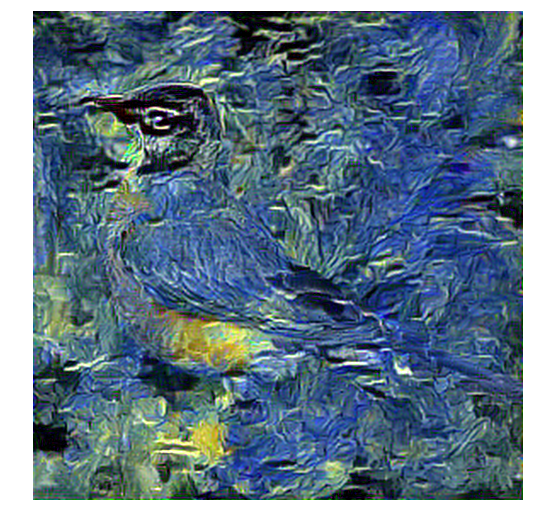

In [105]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]
plt.figure(figsize=(9,9))
plt.imshow(x, interpolation='lanczos')
plt.axis('off');

The main take away is: to solve something with a NN, 
all we’ve got to do is set up a loss function and then optimize something. 
And the loss function is something which a lower number is something that you’re happier with. 
Because then when you optimize it, it’s going to make that number as low as it can, 
and it’ll do what you wanted it to do. 
So here, Gattys came up with the loss function that does a good job of being a smaller number when it looks like the thing we want it to look like, and it looks like the style of the thing we want to be in the style of. 
That’s all we had to do.

In [106]:
for sf in sfs: sf.close()

What it actually comes to it [1:59:10], apart from implementing Gram MSE loss which was like 6 lines of code if that, that’s our loss function:

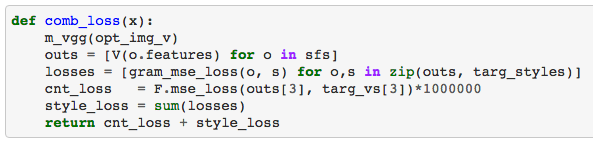

Pass it to our optimizer, and wait about 5 seconds, and we are done. 
And remember, we could do a batch of these at a time, so we could wait 5 seconds and 64 of these will be done. 
This paper has inspired a lot of interesting work. 
More interesting work will combine human creativity with these kinds of tools. 
I haven’t seen much in the way of tools that you can download or use where the artist is in control and can kind of do things interactively. 

The [Google Magenta](https://ai.google/research/teams/brain/magenta/) project (creative AI) is building tools that musicians can use to perform in real time. At their website, there’s all kinds of things where you can press the buttons to actually change the drum beats, melodies, keys, etc. 
Adobe or Nvidia are starting to release prototypes.
But a creative AI explosion hasn’t happened yet. 
We have the technology but no one’s put it together and said 
“look at the thing I built and look at the stuff that people built with my thing.” 
So that’s just a huge area of opportunity.

Interesting picture on the Gattys’ paper, different convolutional layers for the style, 
different style to content ratios, and here’s the different images (this isn’t Van Gogh, is a different combination). So you can see, if you just do all style, you don’t see any image. 
If we do lots of content, but use low enough convolutional layer, it looks OK but the background is dumb. 
So we want somewhere in the middle to experiment. 

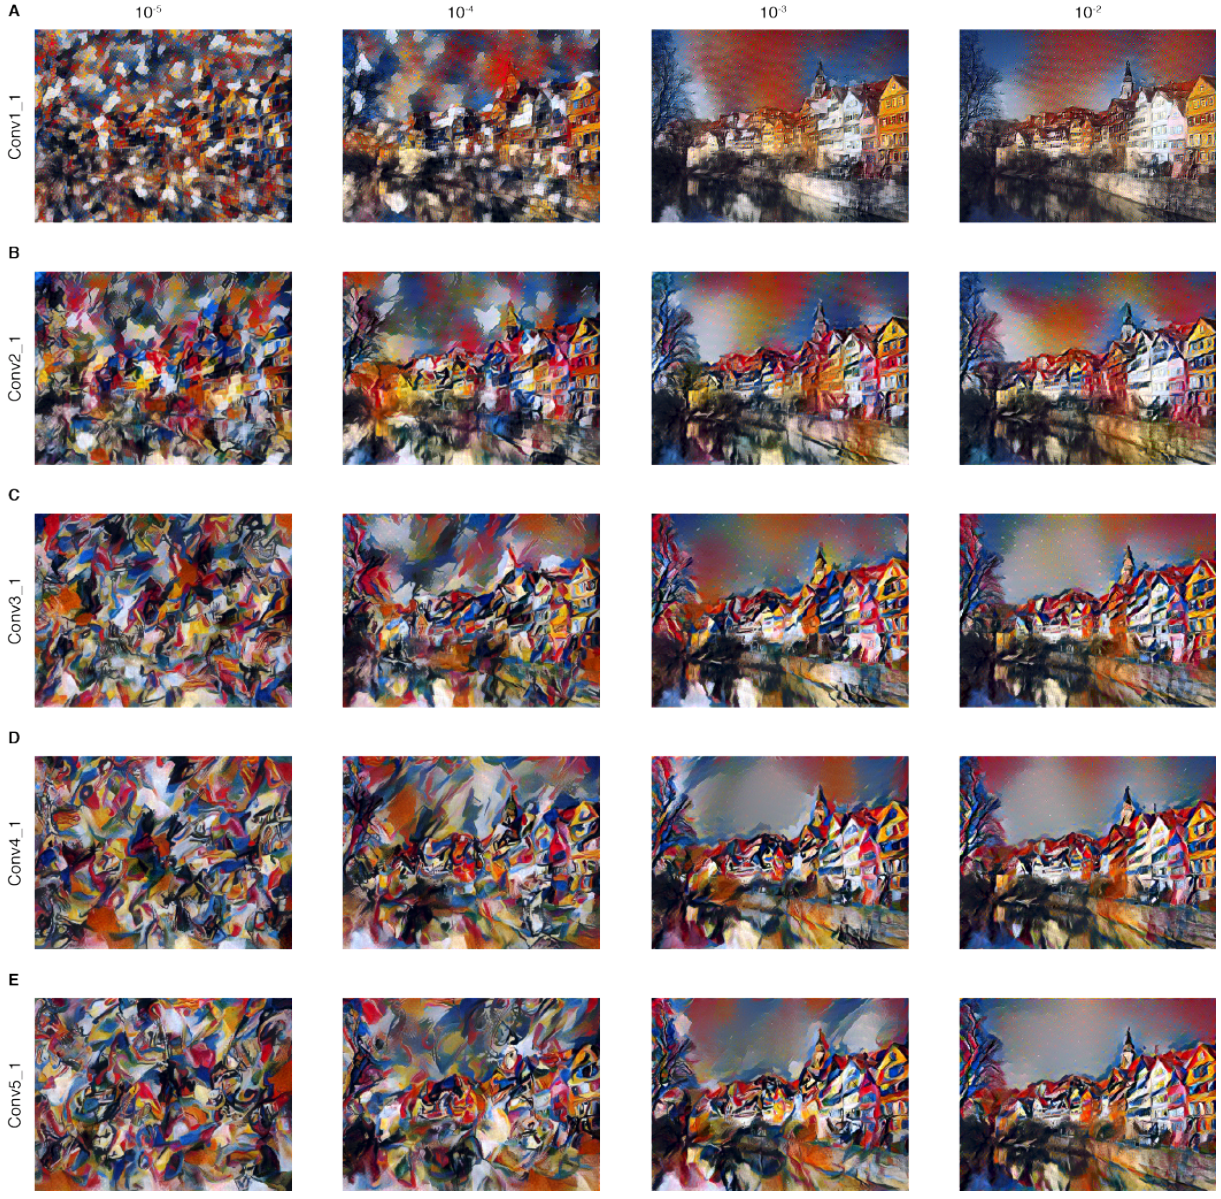